In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.api import Logit
from psmpy import PsmPy
from psmpy.functions import cohenD
import matplotlib.pyplot as plt

# Criando dados simulados

In [2]:
# Dados simulados
np.random.seed(400)
N = 2000

# Características das observacoes
X1 = np.random.normal(0.3, 1, N)
X2 = np.random.normal(0.3, 1, N)
X3 = np.random.normal(0.3, 1, N)

# Probabilidade de receber o tratamento - dependente das covariaveis
p = 1 / (1 + np.exp(-((0.2 * X1) + (0.2 * X2) + (0.2 * X3))))

# Atribuição ao tratamento com base na probabilidade
treatment = np.random.binomial(1, p)

# Variável resposta (Y) dependente do tratamento e das covariáveis
Y = (8 * treatment) + (2 * X1) + (3 * X2) + (4 * X3) + np.random.normal(size=N)

# Construindo o DataFrame
df = pd.DataFrame({'X1': X1, 'X2': X2, 'X3': X3, 'treatment': treatment, 'Y': Y})

In [3]:
df.head()

,X1,X2,X3,treatment,Y
0,-0.830571,-0.345197,0.073416,1,5.628789
1,0.996200,2.544138,1.056202,0,13.379357
2,-0.132293,1.340311,-0.277241,1,9.908344
3,1.041020,1.586583,-1.154941,1,11.049054
4,-0.178137,0.997762,-0.937351,0,-1.494795


In [4]:
df['treatment'].value_counts()

treatment
1    1111
0     889
Name: count, dtype: int64

In [5]:
df.groupby(['treatment'])['Y'].mean()

treatment
0     1.755599
1    11.540707
Name: Y, dtype: float64

# Calculando Propensity Score Inicial

In [6]:
# Estimando o Propensity Score com Regressão Logística
logit = LogisticRegression()
logit.fit(df[['X1', 'X2', 'X3']], df['treatment'])

# Adicionando o Propensity Score ao DataFrame
df['propensity_score'] = logit.predict_proba(df[['X1', 'X2', 'X3']])[:, 1]

# Visualizando os primeiros dados
df.head()

,X1,X2,X3,treatment,Y,propensity_score
0,-0.830571,-0.345197,0.073416,1,5.628789,0.456671
1,0.996200,2.544138,1.056202,0,13.379357,0.708867
2,-0.132293,1.340311,-0.277241,1,9.908344,0.540591
3,1.041020,1.586583,-1.154941,1,11.049054,0.568587
4,-0.178137,0.997762,-0.937351,0,-1.494795,0.489371


# Verificando a distribuicao dos scores

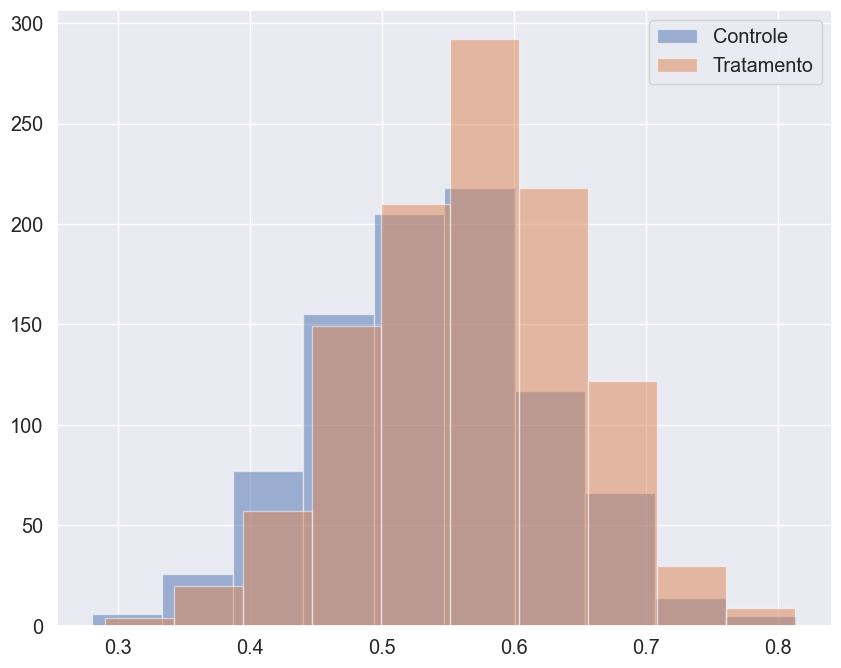

In [7]:
plt.hist(df[df['treatment'] == 0]['propensity_score'], label = 'Controle', alpha = 0.5)
plt.hist(df[df['treatment'] == 1]['propensity_score'], label = 'Tratamento', alpha = 0.5)
plt.legend()
plt.show()

# Definindo suporte comum entre os scores de tratamento/controle

In [8]:
# Determinando os valores mínimo e máximo do propensity score em ambos os grupos
min_treated = df[df['treatment'] == 1]['propensity_score'].min()
max_treated = df[df['treatment'] == 1]['propensity_score'].max()
min_control = df[df['treatment'] == 0]['propensity_score'].min()
max_control = df[df['treatment'] == 0]['propensity_score'].max()

# Definindo a região de suporte comum
common_support_min = max(min_treated, min_control)
common_support_max = min(max_treated, max_control)

# Aplicando o corte (trimming) para manter apenas as observações dentro do suporte comum
df_trimmed = df[(df['propensity_score'] >= common_support_min) & 
                (df['propensity_score'] <= common_support_max)]

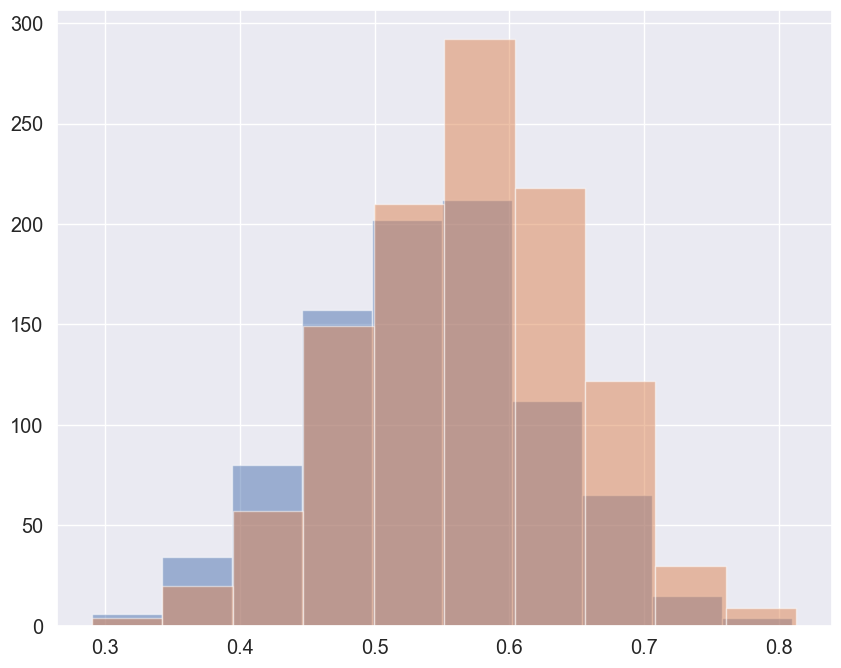

In [9]:
plt.hist(df_trimmed[df_trimmed['treatment'] == 0]['propensity_score'], label = 'Controle', alpha = 0.5)
plt.hist(df_trimmed[df_trimmed['treatment'] == 1]['propensity_score'], label = 'Tratamento', alpha = 0.5)
plt.show()

In [10]:
df_trimmed.head()

,X1,X2,X3,treatment,Y,propensity_score
0,-0.830571,-0.345197,0.073416,1,5.628789,0.456671
1,0.996200,2.544138,1.056202,0,13.379357,0.708867
2,-0.132293,1.340311,-0.277241,1,9.908344,0.540591
3,1.041020,1.586583,-1.154941,1,11.049054,0.568587
4,-0.178137,0.997762,-0.937351,0,-1.494795,0.489371


In [11]:
df_trimmed.drop('propensity_score', axis=1, inplace=True)

C:\Users\gcabr\AppData\Local\Temp\ipykernel_22520\3567244812.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trimmed.drop('propensity_score', axis=1, inplace=True)


# Recalculando Score e pareamento das observacoes - KNN

In [12]:
df_trimmed['ID'] = df_trimmed.index

C:\Users\gcabr\AppData\Local\Temp\ipykernel_22520\4276330821.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trimmed['ID'] = df_trimmed.index


In [13]:
df_trimmed.head()

,X1,X2,X3,treatment,Y,ID
0,-0.830571,-0.345197,0.073416,1,5.628789,0
1,0.996200,2.544138,1.056202,0,13.379357,1
2,-0.132293,1.340311,-0.277241,1,9.908344,2
3,1.041020,1.586583,-1.154941,1,11.049054,3
4,-0.178137,0.997762,-0.937351,0,-1.494795,4


In [14]:
# Aplicando o Propensity Score Matching com os dados ajustados
psm = PsmPy(df_trimmed, treatment='treatment', indx='ID', exclude = ['Y'])
psm.logistic_ps(balance = True)

In [15]:
psm.predicted_data.head()

,ID,X1,X2,X3,propensity_score,propensity_logit,treatment
0,9,0.483293,-0.635629,0.642763,0.489743,-0.041033,0
1,13,1.305500,-0.933070,-0.685513,0.449002,-0.204704,0
2,21,-0.279494,1.185114,-2.270197,0.370216,-0.531290,0
3,51,2.387179,0.838715,0.196143,0.615083,0.468728,0
4,54,-0.014224,0.642034,0.113926,0.485998,-0.056025,0


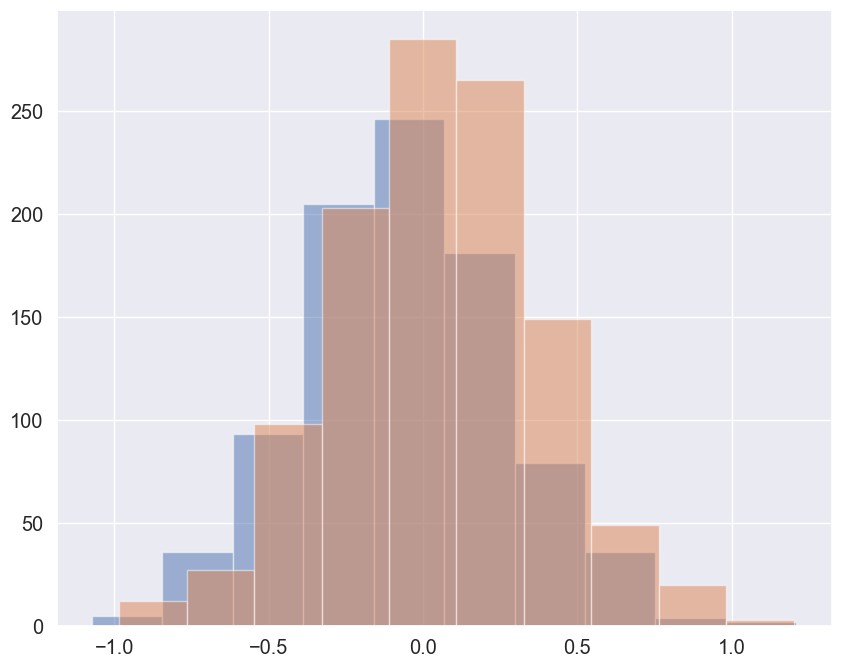

In [16]:
plt.hist(psm.predicted_data[psm.predicted_data['treatment'] == 0]['propensity_logit'], label = 'Controle', alpha = 0.5)
plt.hist(psm.predicted_data[psm.predicted_data['treatment'] == 1]['propensity_logit'], label = 'Tratamento', alpha = 0.5)
plt.show()

In [17]:
# Pareamento do Vizinho Mais Próximo com caliper
psm.knn_matched(matcher='propensity_score', caliper=1, replacement = True, drop_unmatched = True)

In [22]:
len(psm.df_matched[psm.df_matched['treatment'] == 0])

887

# Qualidade do pareamento

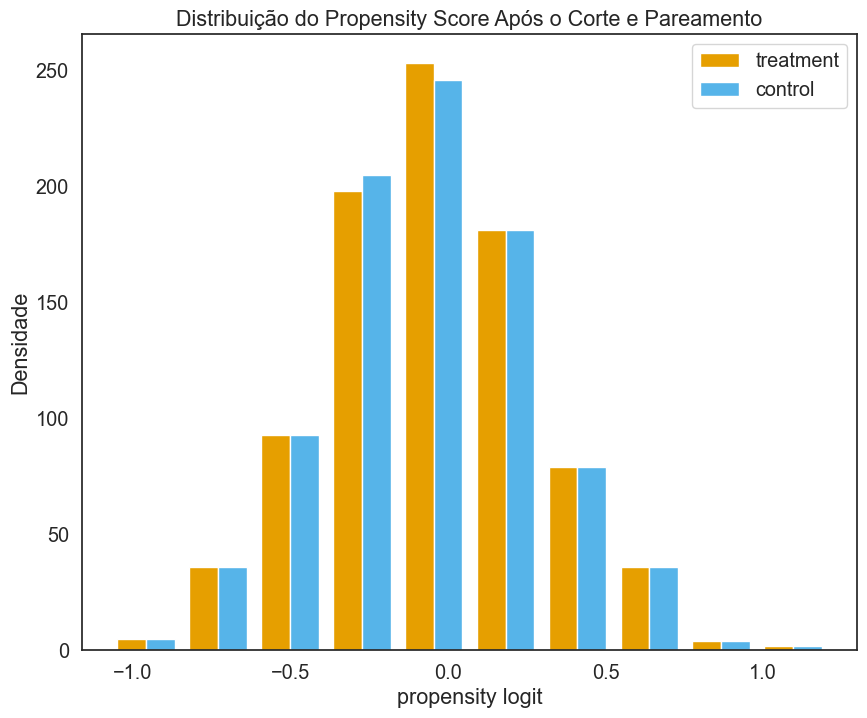

In [23]:
# Avaliação da qualidade do pareamento após o corte
psm.plot_match(Title='Distribuição do Propensity Score Após o Corte e Pareamento', Ylabel='Densidade')

In [24]:
print(cohenD(psm.df_matched, 'treatment', metricName='X1'))
print(cohenD(psm.df_matched, 'treatment', metricName='X2'))
print(cohenD(psm.df_matched, 'treatment', metricName='X3'))

0.014316550147560787
0.029368750984369363
0.01975588656574497


# Efeito Medio do Tratamento

In [25]:
psm.df_matched.head()

,ID,X1,X2,X3,propensity_score,propensity_logit,treatment,matched_ID
0,9,0.483293,-0.635629,0.642763,0.489743,-0.041033,0,1340.0
1,13,1.305500,-0.933070,-0.685513,0.449002,-0.204704,0,1955.0
2,21,-0.279494,1.185114,-2.270197,0.370216,-0.531290,0,1256.0
3,51,2.387179,0.838715,0.196143,0.615083,0.468728,0,1049.0
4,54,-0.014224,0.642034,0.113926,0.485998,-0.056025,0,1625.0


In [26]:
df_trimmed.head()

,X1,X2,X3,treatment,Y,ID
0,-0.830571,-0.345197,0.073416,1,5.628789,0
1,0.996200,2.544138,1.056202,0,13.379357,1
2,-0.132293,1.340311,-0.277241,1,9.908344,2
3,1.041020,1.586583,-1.154941,1,11.049054,3
4,-0.178137,0.997762,-0.937351,0,-1.494795,4


In [27]:
# Identificar os tratados e seus correspondentes no grupo de controle
# Vamos dividir o DataFrame em tratados e controles
control = psm.df_matched[psm.df_matched['treatment'] == 0]
treated = psm.df_matched[psm.df_matched['treatment'] == 1]

# Fazer o merge (junção) com base no 'matched_ID' para combinar pares
pairs = pd.merge(control, treated, how = 'left', left_on='matched_ID', right_on='ID' ,suffixes=('_control', '_treated'))

In [28]:
pairs.head()

,ID_control,X1_control,X2_control,X3_control,propensity_score_control,propensity_logit_control,treatment_control,matched_ID_control,ID_treated,X1_treated,X2_treated,X3_treated,propensity_score_treated,propensity_logit_treated,treatment_treated,matched_ID_treated
0,9,0.483293,-0.635629,0.642763,0.489743,-0.041033,0,1340.0,1340,1.184398,-1.274536,0.133046,0.489743,-0.041035,1,NaN
1,13,1.305500,-0.933070,-0.685513,0.449002,-0.204704,0,1955.0,1955,0.686978,0.696677,-1.004466,0.449079,-0.204394,1,NaN
2,13,1.305500,-0.933070,-0.685513,0.449002,-0.204704,0,1955.0,1955,0.686978,0.696677,-1.004466,0.449079,-0.204394,1,NaN
3,13,1.305500,-0.933070,-0.685513,0.449002,-0.204704,0,1955.0,1955,0.686978,0.696677,-1.004466,0.449079,-0.204394,1,NaN
4,21,-0.279494,1.185114,-2.270197,0.370216,-0.531290,0,1256.0,1256,-0.006672,-1.519102,-0.795176,0.369686,-0.533566,1,NaN


In [31]:
pairs.drop_duplicates(inplace=True)

In [32]:
len(pairs)

887

In [33]:
#anexando valores resposta
pairs_v2 = pd.merge(pairs, df_trimmed[['ID','Y']], how = 'left', left_on='ID_control', right_on='ID')
pairs_v2.rename(columns={'Y': 'Y_control'}, inplace=True)
pairs_v2.drop_duplicates(inplace=True)
pairs_v3 = pd.merge(pairs_v2, df_trimmed[['ID','Y']], how = 'left', left_on='ID_treated', right_on='ID')
pairs_v3.rename(columns={'Y': 'Y_treated'}, inplace=True)
pairs_v3.drop_duplicates(inplace=True)

In [34]:
pairs_v3.head()

,ID_control,X1_control,X2_control,X3_control,propensity_score_control,propensity_logit_control,treatment_control,matched_ID_control,ID_treated,X1_treated,X2_treated,X3_treated,propensity_score_treated,propensity_logit_treated,treatment_treated,matched_ID_treated,ID_x,Y_control,ID_y,Y_treated
0,9,0.483293,-0.635629,0.642763,0.489743,-0.041033,0,1340.0,1340,1.184398,-1.274536,0.133046,0.489743,-0.041035,1,NaN,9,1.579303,1340,8.424341
1,13,1.305500,-0.933070,-0.685513,0.449002,-0.204704,0,1955.0,1955,0.686978,0.696677,-1.004466,0.449079,-0.204394,1,NaN,13,-3.442367,1955,8.095400
2,21,-0.279494,1.185114,-2.270197,0.370216,-0.531290,0,1256.0,1256,-0.006672,-1.519102,-0.795176,0.369686,-0.533566,1,NaN,21,-5.786941,1256,0.386391
3,51,2.387179,0.838715,0.196143,0.615083,0.468728,0,1049.0,1049,1.199242,0.850671,1.175680,0.615181,0.469144,1,NaN,51,8.367107,1049,18.056371
4,54,-0.014224,0.642034,0.113926,0.485998,-0.056025,0,1625.0,1625,-1.261770,-0.169224,1.559619,0.485991,-0.056051,1,NaN,54,4.002706,1625,11.185688


In [35]:
len(pairs_v3)

887

In [36]:
# Calcular a diferença no resultado (desfecho Y) entre os pares
pairs_v3['diff_Y'] = pairs_v3['Y_treated'] - pairs_v3['Y_control']

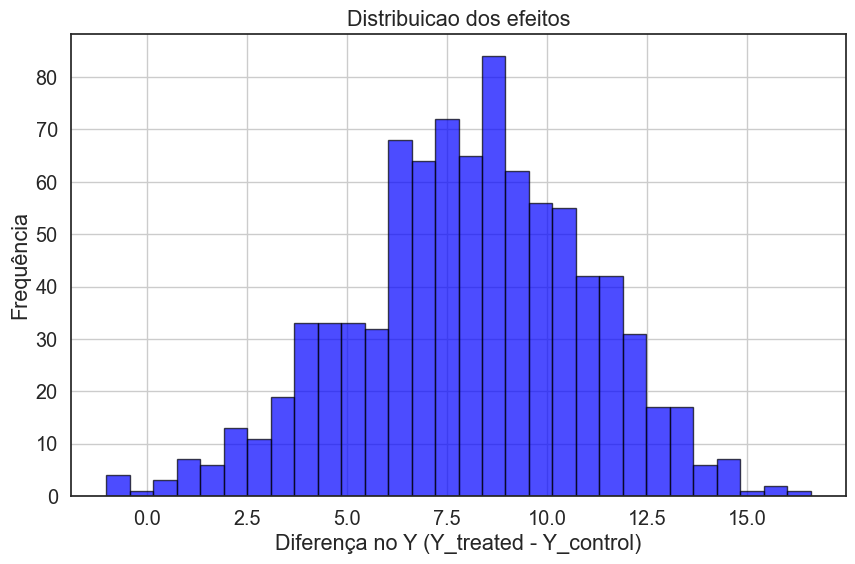

In [40]:
# Plotar a distribuição da diferença no desfecho Y entre os pares
plt.figure(figsize=(10, 6))
plt.hist(pairs_v3['diff_Y'], bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title('Distribuicao dos efeitos')
plt.xlabel('Diferença no Y (Y_treated - Y_control)')
plt.ylabel('Frequência')
plt.grid(True)
plt.show()

In [41]:
# Calcular estatísticas descritivas das diferenças
diff_stats = pairs_v3['diff_Y'].describe()

# Exibir estatísticas descritivas
print("Estatísticas:")
print(diff_stats)

Estatísticas:
count    887.000000
mean       8.065810
std        2.939862
min       -1.014226
25%        6.224119
50%        8.211368
75%       10.113417
max       16.594487
Name: diff_Y, dtype: float64
